
# Predicting Bankruptcy in the mining industry with Altman's Z-score and the Calcbench API

Edward Altman's Z-score is a formula for predicting corporate bankruptcy.  Below we plot the change in industry aggregate Z-scores for mining companies.  A Z-score above 2.99 is considered "safe", between 1.81 and 2.99 is a "gray" zone, below 1.81 is the "distress" zone.  The troubles in the coal and metal mining industry are clearly illustrated.

[Altman's Z-score @ Wikipedia](https://en.wikipedia.org/wiki/Altman_Z-score)

To replicate the below [sign up for a Calcbench account](https://www.calcbench.com/join), install the Calcbench Python API client from [here](https://github.com/calcbench/python_api_client) and download this note book from [github](https://github.com/calcbench/notebooks/blob/master/z-score.ipynb).

In [1]:
import calcbench as cb
import pandas as pd
pd.options.display.max_rows = 1000
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
z_score_metrics = ['CurrentAssets',
                   'CurrentLiabilities', 
                   'Assets', 
                   'RetainedEarnings', 
                   'EBIT', 
                   'MarketCapAtEndOfPeriod',
                   'Liabilities',
                   'Revenue']

In [3]:
SIC_codes = {
    "Oil And Gas Extraction" : 1300,
    "Metal Mining" : 1000,
    "Coal Mining" : 1200,
    "Mining Nonmetallic Minerals" : 1400,
}

In [15]:
def get_z_score_inputs(tickers):
    z_score_data = cb.normalized_dataframe(company_identifiers=list(tickers), 
                                           metrics=z_score_metrics, 
                                           start_year=2008, start_period=0, 
                                           end_year=2015, end_period=0)
    return z_score_data

In [7]:
def peer_group_z_score(peer_group):
    peer_group = peer_group[(peer_group.ticker != 'GMC') & (peer_group.ticker != 'PPI')] #GMC's marketvalue is off
    z_score_data = get_z_score_inputs(peer_group.ticker)
    aggregate_data = z_score_data.sum(level=[0], axis=1)
    return compute_z_score(aggregate_data), z_score_data

In [18]:
def compute_z_score(inputs):
    #from https://github.com/calcbench/notebooks/blob/master/z-score.ipynb
    working_capital = inputs['CurrentAssets'] - inputs['CurrentLiabilities']
    

    z_score = (1.2 * (working_capital / inputs['Assets']) + 
              1.4 * (inputs['RetainedEarnings'] / inputs['Assets']) +
              3.3 * (inputs['EBIT'] / inputs['Assets']) +
              0.6 * (inputs['MarketCapAtEndOfPeriod'] / inputs['Liabilities']) +
              .99 * (inputs['Revenue'] / inputs['Assets']))
    
    return z_score

In [61]:
peer_groups = [(industry, cb.companies(SIC_codes=[SIC_code])) for industry, SIC_code in SIC_codes.items()]
sp500 = cb.companies(index="SP500")
sp500_no_financials = sp500[sp500.sic_code & ((sp500.sic_code < 6000) | (sp500.sic_code >= 7000))] # There is a different z-score formulas for financials.
peer_groups.append(("SP500 (no financials)", sp500_no_financials))
industry_z_scores = [(industry, peer_group_z_score(peer_group)[0]) for industry, peer_group in peer_groups]
z_scores = pd.DataFrame.from_items(industry_z_scores)

In [3]:
coal_peer_group = cb.companies(SIC_codes=[1200])

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:315: SNIMissingWarning: An HTTPS request has been made, but the SNI (Subject Name Indication) extension to TLS is not available on this platform. This may cause the server to present an incorrect TLS certificate, which can cause validation failures. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#snimissingwarning.
  SNIMissingWarning
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/requests/packages/urllib3/util/ssl_.py:120: InsecurePlatformWarning: A true SSLContext object is not available. This prevents urllib3 from configuring SSL appropriately and may cause certain SSL connections to fail. For more information, see https://urllib3.readthedocs.org/en/latest/security.html#insecureplatformwarning.
  InsecurePlatformWarning


In [16]:
z_score_inputs = get_z_score_inputs(coal_peer_group.ticker)

In [19]:
compute_z_score(z_score_inputs)

ticker,ACI,AHGP,ANR,ARLP,AWSR,BRNE,BTU,CERX,CHGY,CIK0001255895,...,LLEN,MEE,NRP,PCX,ROYE,SGBHF,SGZH,WLB,WLT,WMLP
period,,,,,,,,,,,,,,,,,,,,,
2008,NaN,NaN,3.516771,NaN,NaN,NaN,1.973063,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009,1.496238,NaN,2.044533,NaN,NaN,NaN,2.440364,NaN,NaN,NaN,...,NaN,1.445947,NaN,1.136516,NaN,NaN,NaN,NaN,4.080467,NaN
2010,2.372645,NaN,2.926864,NaN,NaN,NaN,3.034724,NaN,2.767974,NaN,...,NaN,0.840861,NaN,0.918735,NaN,NaN,NaN,0.353887,6.633498,NaN
2011,0.872310,NaN,0.617583,NaN,NaN,NaN,1.211939,NaN,2.253454,NaN,...,NaN,NaN,NaN,0.945068,NaN,NaN,NaN,0.167247,1.349729,NaN
2012,0.393262,NaN,-0.201825,NaN,NaN,NaN,0.365003,NaN,2.026840,NaN,...,NaN,NaN,NaN,-0.170363,-21.210232,NaN,NaN,0.349266,0.074153,NaN
2013,0.211907,NaN,-0.139347,NaN,NaN,2.313948,0.209699,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.496324,0.277818,NaN
2014,0.247459,NaN,-0.287496,NaN,NaN,-146.832843,0.636837,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.221297,-0.081414,NaN
2015,-3.553939,NaN,NaN,NaN,NaN,NaN,-0.535779,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,146.242391,NaN,NaN,0.043883,NaN,NaN


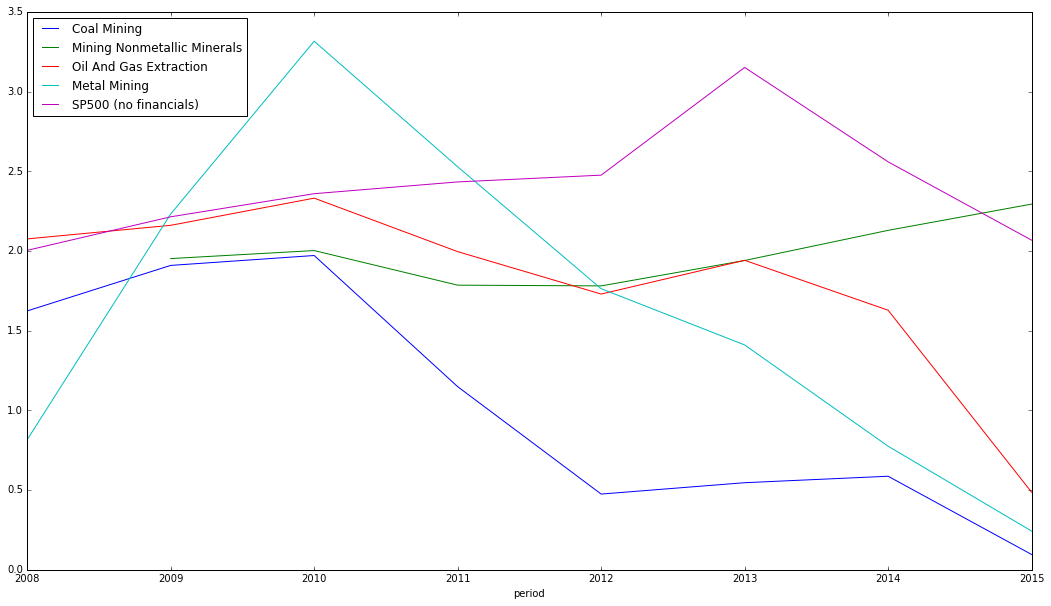

In [62]:
z_scores.plot(figsize=(18, 10))

In [69]:
z_score, data = peer_group_z_score(peer_groups[0][1])

In [78]:
compute_z_score(data.swaplevel(0, 1, 1).ACI)

period
2008         NaN
2009    1.496238
2010    2.372645
2011    0.872310
2012    0.393262
2013    0.211907
2014    0.247459
2015         NaN
Freq: A-DEC, dtype: float64